In [100]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [101]:
def order_points(points):
    rect = np.zeros((4, 2), dtype="float32")
    s = points.sum(axis=1)
    rect[0] = points[np.argmin(s)]
    rect[2] = points[np.argmax(s)]
    diff = np.diff(points, axis=1)
    rect[1] = points[np.argmin(diff)]
    rect[3] = points[np.argmax(diff)]
    return rect

In [102]:

def four_point_transform(image, points):
    rect = order_points(points)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

In [103]:
def get_points(image):
    # Define the four corners of the object in the image
    points = []
    def click_event(event, x, y, flags, params):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            if len(points) == 4:
                cv2.destroyWindow('image')
            else:
                cv2.circle(image, (x, y), 5, (0, 255, 0), -1)
                cv2.imshow('image', image)
    cv2.imshow('image', image)
    cv2.setMouseCallback('image', click_event)
    cv2.waitKey(0)
    
    return np.array(points)

In [104]:
image = cv2.imread("./pictures/2.jpg")
points = get_points(image)

In [177]:
def filter_black_pieces(image, points):
    topdown = four_point_transform(image, points)

    # Convert to grayscale
    gray = cv2.cvtColor(topdown, cv2.COLOR_BGR2GRAY)

    # Convert the image to HSV color space
    hsv = cv2.cvtColor(topdown, cv2.COLOR_BGR2HSV)

    # Define the HSV range for the green color
    lower_green = np.array([45, 100, 50])
    upper_green = np.array([75, 255, 255])

    # Define the color range for the black pieces
    lower_black = np.array([0, 0, 0], dtype="uint8")
    upper_black = np.array([100, 70, 100], dtype="uint8")

    # Define the color range for the white pieces
    lower_white = np.array([120, 120, 120], dtype="uint8")
    upper_white = np.array([255, 255, 255], dtype="uint8")

    # Filter out the green color
    mask_green = cv2.inRange(hsv, lower_green, upper_green)
    #topdown[mask_green > 0] = (0, 0, 0)

    # Filter out the black pieces
    mask_black = cv2.inRange(topdown, lower_black, upper_black)
    filtered_black = cv2.bitwise_and(gray, gray, mask=mask_black)
    
    # Filter out the white pieces
    mask_white = cv2.inRange(topdown, lower_white, upper_white)
    filtered_white = cv2.bitwise_and(gray, gray, mask=mask_white)

    return filtered_black


(-0.5, 738.5, 521.5, -0.5)

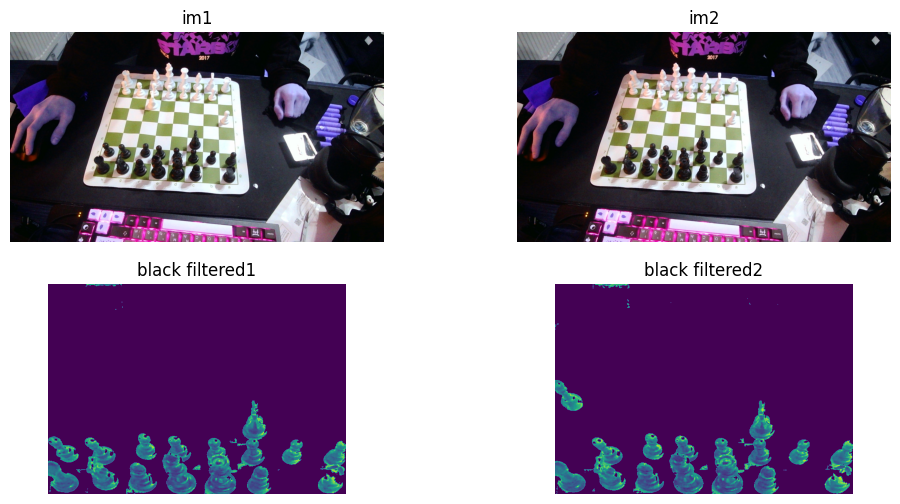

In [180]:
# Display the resulting images
image1 = cv2.imread("./pictures/6.jpg")
image2 = cv2.imread("./pictures/7.jpg")
b1 = filter_black_pieces(image1)
b2 = filter_black_pieces(image2)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes[0,0].imshow(image1)
axes[0,0].set_title(f"im1")
axes[0,0].axis("off")

axes[0,1].imshow(image2)
axes[0,1].set_title(f"im2")
axes[0,1].axis("off")

axes[1,0].imshow(b1)
axes[1,0].set_title(f"black filtered1")
axes[1,0].axis("off")

axes[1,1].imshow(b2)
axes[1,1].set_title(f"black filtered2")
axes[1,1].axis("off")

In [188]:
def get_move(imageOld, imageNew):
    filteredOld = filter_black_pieces(imageOld)
    filteredNew = filter_black_pieces(imageNew)
    # Apply a Gaussian blur to reduce noise
    blurredOld = cv2.GaussianBlur(filteredOld, (21, 21), 0)
    blurredNew = cv2.GaussianBlur(filteredNew, (21, 21), 0)

    # Calculate the difference between the two frames
    diff = cv2.absdiff(blurredOld, blurredNew)

    # Threshold the difference image to remove small changes
    thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)[1]

    # Apply a series of dilations and erosions to remove noise
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.dilate(thresh, kernel, iterations=2)
    thresh = cv2.erode(thresh, kernel, iterations=2)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop over the contours
    square_width = filteredOld.shape[1] / 8
    square_height = filteredOld.shape[0] / 8

    move = []
    for contour in contours:
        # If the contour is too small, ignore it
        if cv2.contourArea(contour) < 1000:
            continue

        # Compute the bounding box for the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Draw the bounding box on the frame
        cv2.rectangle(filteredNew, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Calculate the starting and ending squares of the move
        xvalue = int((x+0.5*w) / square_width)
        yvalue = int((y+0.5*h) / square_height)
        square = chr(97 + xvalue) + str(8 - yvalue)
        move.append(square)
    plt.imshow(filteredNew)
    return move
    

['a2', 'a4']

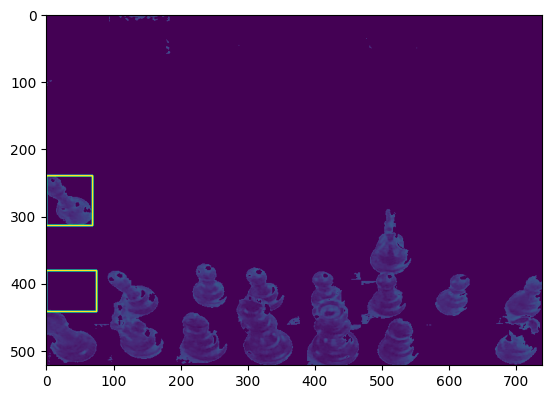

In [189]:
image1 = cv2.imread("./pictures/6.jpg")
image2 = cv2.imread("./pictures/7.jpg")
get_move(image1, image2)